<a href="https://colab.research.google.com/github/mishabar410/ML/blob/main/TransAttUnet/ds_cup_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import os
# from IPython.display import clear_output

# ! pip install -q kaggle
# from google.colab import files
# files.upload()
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

# ! kaggle competitions download -c 'data-science-bowl-2018' 
# !unzip '/content/data-science-bowl-2018.zip' -d '/content/data/'
# !unzip '/content/data/stage1_train.zip' -d '/content/train_data/'
# # !unzip '/content/data/stage1_test.zip' -d '/content/test_data'

# # clear = lambda : os.system('cls')
# # clear()
# clear_output(wait=True)

KeyboardInterrupt: ignored

In [5]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch

from torchsummary import summary
import segmentation_models_pytorch as smp

import statistics 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

TRAIN_PATH = '/content/train_data/'
TEST_PATH = '/content/test_data/'

seed = 42
random.seed = seed
np.random.seed = seed

train_ids = next(os.walk(TRAIN_PATH))[1]
# test_ids = next(os.walk(TEST_PATH))[1]

In [7]:
image_name = []
mask_name = []

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    # path = TRAIN_PATH + id_ + '/images/' + id_
    image_name.append(id_)

image_df = pd.DataFrame({'id': image_name}, index = np.arange(0, len(image_name)))

  0%|          | 0/670 [00:00<?, ?it/s]

In [8]:
X_trainval, X_test = train_test_split(image_df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.1, random_state=19)


print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size     : ', len(X_test))


Train Size   :  542
Val Size     :  61
Test Size     :  67


In [9]:
import random
import torchvision.transforms as T

class RandomChoice(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.t = self.transforms

    def __call__(self, img):
        return self.t(img)

In [10]:
def minmax_norm(img):
    for i in range(len(img)):

        img[i] = img[i] - torch.min(img[i])
        if torch.max(img[i]) != 0:
            img[i] = img[i] / torch.max(img[i])

    return img

class DroneDataset(Dataset):   
    def __init__(self, img_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = imread(self.img_path + self.X[idx] + '/images/' + self.X[idx] + '.png')
        
        img = img[..., :3]

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(self.img_path + self.X[idx] + '/masks/'))[2]:

            mask_ = imread(self.img_path + self.X[idx] + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                        preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)

        # t = T.Resize((128, 128))
        # mask = t(Image.fromarray(np.squeeze(mask)))
        # img = t(Image.fromarray(img))

        # mask = np.squeeze(mask)
        trans = A.Compose([A.Resize(128, 128, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), A.Rotate(limit=45), 
                           A.InvertImg(p=0.3),
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])
        aug = trans(image=img, mask=mask)
        
        img = Image.fromarray(aug['image'])
        mask = aug['mask']

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        # t = T.Compose([T.ToTensor())

        img = t(img)
        mask = torch.from_numpy(mask).long()

        # img = trans(img)
        # mask = trans(mask)
        # mask = self.transform(mask).long()
        # img = self.transform(img)
        # t = T.ToTensor()
        # mask =  t(mask).long()
        # img = t(img)
        # t = T.Normalize(self.mean, self.std)
        mask = mask / 255
        mask = (mask > 0.3).int()
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return minmax_norm(img), mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

In [11]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = T.Compose(
            [T.Resize((128, 128)),
            #  T.RandomHorizontalFlip(), 
            #  T.RandomVerticalFlip(),
            #  T.ColorJitter((0,0.5),(0,0.5)),
             T.ToTensor()])

t_val = t_train

#datasets
train_set = DroneDataset(TRAIN_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(TRAIN_PATH, X_val,  mean, std, t_train, patch=False)

#dataloader
batch_size = 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True) 

<ipython-input-10-8587e963ecca>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


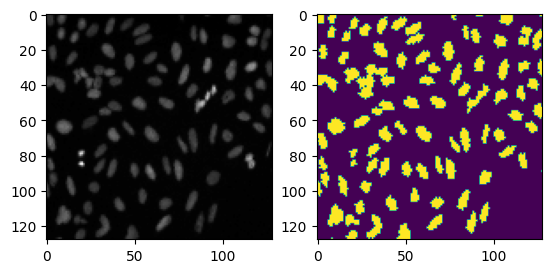

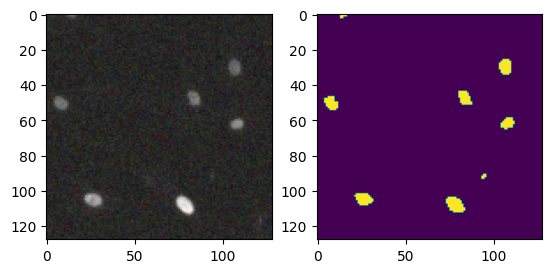

In [12]:
i = 0
for img, mask in train_loader:
    i += 1   
    fig = plt.figure()
    a = fig.add_subplot(1, 2, 1)
    plt.imshow(img[0].permute(1, 2, 0).numpy())

    # plt.show()
    a = fig.add_subplot(1, 2, 2)

    plt.imshow(mask[0].numpy())
    plt.show()
    if (i > 1):
        break
    

# Model

In [13]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 1)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding = 1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)
    
    def forward(self, x):
        x1 = self.relu(self.bnorm1(self.conv1(x)))
        x2 = self.relu(self.bnorm2(self.conv2(x1)))
        return x2

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.mpool = nn.MaxPool2d(kernel_size = 3, stride = 2)

    def forward(self, x):
        return self.conv(self.mpool(x))

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'bilinear')

    def forward(self, x1, x2):
        x1 = self.upsample(x1)

        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x1 = torch.cat([x2, x1], 1)
        return self.conv(x1)

In [14]:
class GSA(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        self.M_conv = nn.Conv2d(in_c, in_c // 8, kernel_size=1)
        self.N_conv = nn.Conv2d(in_c, in_c // 8, kernel_size=1)
        self.W_conv = nn.Conv2d(in_channels = in_c, out_channels = in_c, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        batch_size, channels, height, width = x.size()
        M = self.M_conv(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        N = self.N_conv(x).view(batch_size, -1, height * width)
        W = self.W_conv(x).view(batch_size, -1, height * width)
        B = F.softmax(torch.bmm(M, N), dim = -1).permute(0, 2, 1)
        result = torch.bmm(W, B).view(batch_size, channels, height, width)
        
        return self.gamma * result + x

In [15]:
class Position_Encoding(nn.Module):
    def __init__(self, num_pos_feats=64, len_embedding=128):
        super().__init__()
        self.row_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.col_embed = nn.Embedding(len_embedding, num_pos_feats)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.row_embed.weight)
        nn.init.uniform_(self.col_embed.weight)

    def forward(self, tensor_list):
        x = tensor_list

        # print(x.shape[-2:])
        h, w = x.shape[-2:]
        

        i = torch.arange(w, device = x.device)
        j = torch.arange(h, device = x.device)
        
        x_emb = self.col_embed(i)
        y_emb = self.col_embed(j)


        pos = torch.cat([
            x_emb.unsqueeze(0).repeat(h, 1, 1),
            y_emb.unsqueeze(1).repeat(1, w, 1),
        ], dim = -1).permute(2, 0, 1).unsqueeze(0).repeat(x.shape[0], 1, 1, 1)

        return pos

class Scalar_dot_product_attention(nn.Module):
    def __init__(self, coef):
        super().__init__()
        self.d_k = coef ** 0.5
        self.dropout = nn.Dropout(p = 0.1)

    def forward(self, x):
        batch_size, channels, height, width = x.size()
        q = x.view(batch_size, channels, -1)
        k = x.view(batch_size, channels, -1).permute(0, 2, 1)
        v = x.view(batch_size, channels, -1)
        attention = torch.matmul(q / self.d_k, k)

        attention = F.softmax(attention, dim = -1)
        attention = self.dropout(attention)
        return torch.matmul(attention, v).view(batch_size, channels, height, width)

In [16]:
class Unet(nn.Module):
    def __init__(self, number_of_classes):
        super().__init__()
        self.first_conv = DoubleConv(3, 64)

        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512 // 2)
        # self.down4 = Down(512, 1024 // 2)

        # self.up1 = Up(1024, 512 // 2)
        # self.up1 = Up(512, 256 // 2)
        self.up2 = Up(256 * 2, 128)
        self.up3 = Up(256 * 2, 64)
        self.up4 = Up(256, 64)

        self.out = nn.Conv2d(64 * 2, number_of_classes, kernel_size = 1)

        self.pos = Position_Encoding(128)
        self.gsa = GSA(256)
        self.prod = Scalar_dot_product_attention(256)

    def forward(self, x):

        x1 = self.first_conv(x) # 64
        x2 = self.down1(x1)     # 128
        x3 = self.down2(x2)     # 256
        x4 = self.down3(x3)     # 256

        # x5 = self.down4(x4)

        x4_gsa = self.gsa(x4.clone())
        x4 = x4 + self.pos(x4)
        x4_prod = self.prod(x4.cpu())
        x4 = x4_gsa.cuda() + x4_prod.cuda()

        # x6 = self.up1(x5, x4)
        # x5_scale = F.interpolate(x5, size = x6.shape[2:], mode = 'bilinear', align_corners=True)
        # x6_cat = torch.cat((x6, x5_scale), 1)

        x5 = self.up2(x4, x3) # 128
        x4_scale = F.interpolate(x4, size = x5.shape[2:], mode = 'bilinear', align_corners=True) # 256
        x5_cat = torch.cat((x4_scale, x5), 1) # 384

                
        x6 = self.up3(x5_cat, x2) # 64
        x5_scale = F.interpolate(x5, size = x6.shape[2:], mode = 'bilinear', align_corners=True) # 128
        x6_cat = torch.cat((x5_scale, x6), 1) # 196
        
        x7 = self.up4(x6_cat, x1) # 64
        x6_scale = F.interpolate(x6, size = x7.shape[2:], mode = 'bilinear', align_corners=True) # 64
        x7_cat = torch.cat((x6_scale, x7), 1) # 128

        return self.out(x7_cat)

# Loss

In [17]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = torch.matmul(inputs, targets).sum()                            
        dice = (intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

# Train

In [18]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [19]:
def mIoU(inputs, targets, smooth=1):
    with torch.no_grad():
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = torch.matmul(inputs, targets).sum()                            
        dice = (intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
    return dice

In [36]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    CE_criterion = nn.BCEWithLogitsLoss()

    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device).to(torch.float);
            #forward
            # mask = torch.permute(mask, (0, 3, 1, 2))
            output = model(image).to(torch.float)


            if (i == 0 and e > 0):
                fig1 = plt.figure()

                a = fig1.add_subplot(1, 2, 1)
                plt.plot(train_losses)
                plt.plot(test_losses)
                
                a = fig1.add_subplot(1, 2, 2)
                plt.plot(train_iou)
                plt.plot(val_iou)
                
                plt.show()

            if (i % 50 == 0):

                # img = image * 1000
                img = image[0].clone().cpu().permute(1, 2, 0).numpy()
                # msk = mask * 255
                msk = mask[0].clone().cpu().numpy()   
                
                outpt = nn.Sigmoid()(output)

                outpt = outpt[0].clone().detach().cpu().permute(1, 2, 0).numpy()
                
                fig = plt.figure()

                a = fig.add_subplot(1, 3, 1)
                plt.imshow(img)
                plt.axis('off')

                # plt.show()
                a = fig.add_subplot(1, 3, 2)

                plt.imshow(msk)
                plt.axis('off')

                # plt.show()
                a = fig.add_subplot(1, 3, 3)

                plt.imshow(outpt)
                plt.axis('off')
                plt.show()
            
            # print("image")
            # print(image.size())
            # print("true mask")
            # print(mask.size())
            # print("output")
            # print(output.size())
            
            
            loss = criterion(output.permute(0, 2, 3, 1), mask) + CE_criterion(output.permute(0, 2, 3, 1), mask)
            # print(loss)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device).to(torch.float);
                    output = model(image).to(torch.float)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    # loss = criterion(output, mask) 
                    loss = criterion(output.permute(0, 2, 3, 1), mask) + CE_criterion(output.permute(0, 2, 3, 1), mask)
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(float(running_loss/len(train_loader)))
            test_losses.append(float(test_loss/len(val_loader)))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 3 == 0:
                    print('saving model...')
                    torch.save(model, 'TransAttInet_Dice_CE-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                # if not_improve == 7:
                #     print('Loss not decrease for 7 times, Stop Training')
                #     break
            
            #iou
            val_iou.append(float(val_iou_score/len(val_loader)))
            train_iou.append(float(iou_score/len(train_loader)))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

# text

  0%|          | 0/181 [00:00<?, ?it/s]

<ipython-input-10-8587e963ecca>:27: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)


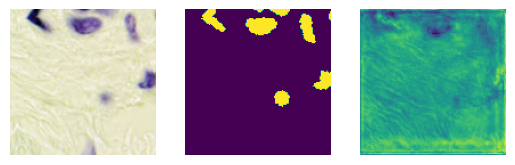

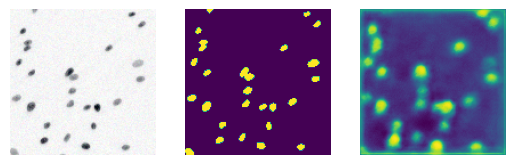

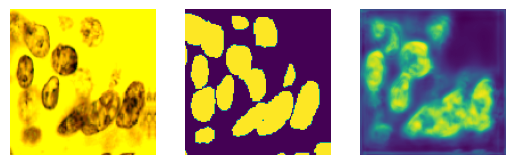

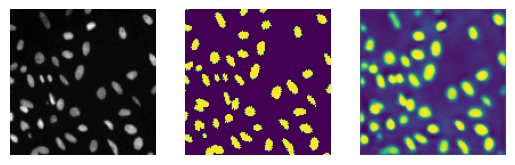

  0%|          | 0/21 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.136 
Epoch:1/20.. Train Loss: 1.254.. Val Loss: 1.136.. Train mIoU:0.185.. Val mIoU: 0.224.. Train Acc:0.146.. Val Acc:0.169.. Time: 3.94m


  0%|          | 0/181 [00:00<?, ?it/s]

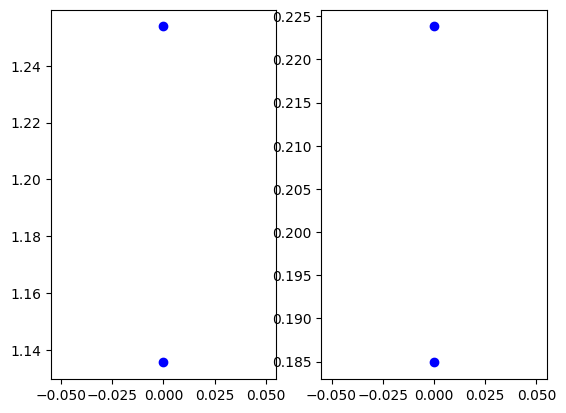

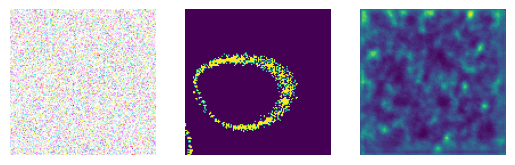

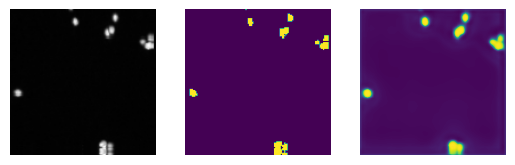

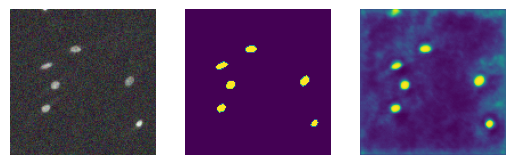

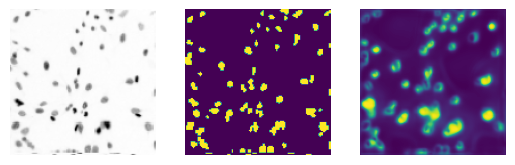

  0%|          | 0/21 [00:00<?, ?it/s]

Loss Decreasing.. 1.136 >> 1.024 
saving model...
Epoch:2/20.. Train Loss: 1.088.. Val Loss: 1.024.. Train mIoU:0.222.. Val mIoU: 0.236.. Train Acc:0.146.. Val Acc:0.163.. Time: 4.05m


  0%|          | 0/181 [00:00<?, ?it/s]

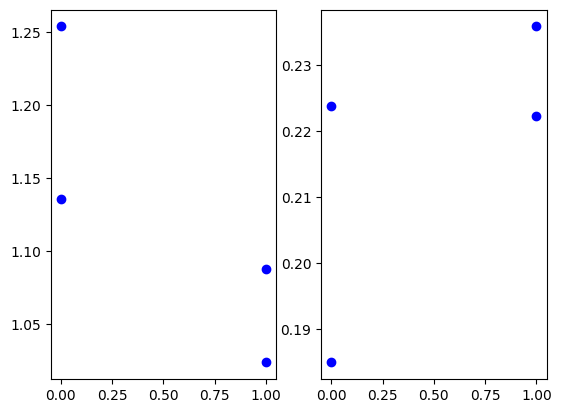

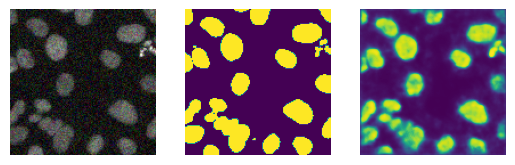

KeyboardInterrupt: ignored

In [37]:
max_lr = 1e-3
epoch = 20
weight_decay = 1e-4

model = Unet(1)
# model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=1, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])
# criterion = nn.BCEWithLogitsLoss()
сriterion = DiceLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, сriterion, optimizer, sched)


In [ ]:
!pip install torchmetrics

In [ ]:
from torchmetrics import JaccardIndex
jaccard = JaccardIndex(task="binary")

with torch.no_grad():
    for i, data in enumerate(tqdm(val_loader)):
        image_tiles, mask_tiles = data

        image_tiles, mask_tiles = data

        bs, c, h, w = image_tiles.size()
        image_tiles = image_tiles.view(-1,c, h, w)
        mask_tiles = mask_tiles.view(-1, h, w)

        image_tiles = image_tiles.view(-1,c, h, w)
        mask_tiles = mask_tiles.view(-1, h, w)
                    
        image = image_tiles.to(device); mask = mask_tiles.to(device).to(torch.float);
        output = model(image).to(torch.float)
        output = (output > 0.5).int()
        output = output.view(-1).float()
        mask = mask.view(-1)
        # mask.apply()
        # n, bins, patches = plt.hist(np.sort(output.numpy()), bins=10, range=[0.0, 1.0])
        # plt.plot(bins)
        # plt.show()
        intersection = torch.matmul(output, mask).sum()                            
        dice = (2 * intersection + 1e-6)/(output.sum() + mask.sum() + 1e-6)
        print(dice)
        # print(mIoU(mask, mask))
        # print(jaccard(torch.squeeze(F.sigmoid(output)), mask))

        

In [ ]:
torch.save({
            'epoch': 15,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, 'CE_DICE.pt')

# Evaluation

In [ ]:
test_set = DroneDataset(TRAIN_PATH, X_test, mean, std, t_train, patch=False)

In [ ]:
model = Unet(1)

checkpoint = torch.load('CE_DICE.pt')
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']

# model.eval()
# # - or -
# model.train()
model = model.cuda()

In [ ]:
for data in test_set:
            #training phase
            
            image_tiles, mask_tiles = data
            
            image = image_tiles.to(device); mask = mask_tiles.to(device).to(torch.float);
            #forward
            # mask = torch.permute(mask, (0, 3, 1, 2))
            image = image.unsqueeze(0).cuda()
            mask = mask.unsqueeze(0).cuda()
            
            output = model(image).to(torch.float)

            img = image * 1000
            img = img[0].cpu().permute(1, 2, 0).numpy().astype(np.uint8) 
            msk = mask * 255
            msk = msk[0].cpu().permute(1, 2, 0).numpy().astype(np.uint8)   
                            
            outpt = nn.Sigmoid()(output) * 255

            outpt1 = (outpt[0] > 0.999).int().detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
            outpt2 = outpt[0].detach().cpu().permute(1, 2, 0).numpy().astype(np.uint8)
                            
            fig = plt.figure()

            a = fig.add_subplot(1, 4, 1)
            plt.imshow(img)
            plt.axis('off')

                            # plt.show()
            a = fig.add_subplot(1, 4, 2)

            plt.imshow(msk)
            plt.axis('off')

                            # plt.show()
            a = fig.add_subplot(1, 4, 3)

            plt.imshow(outpt1)
            plt.axis('off')

            a = fig.add_subplot(1, 4, 4)

            plt.imshow(outpt2)
            plt.axis('off')
            plt.show()

In [ ]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    # t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    # image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)

        output = model(image).to(torch.float)
        score = mIoU(output.cpu(), mask.to(torch.float).cpu())
        # masked = torch.argmax(output, dim=1)
        # masked = masked.cpu().squeeze(0)
    return score

In [ ]:
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
image, mask = test_set[3]
score = predict_image_mask_miou(model, image, mask)
print(score)

In [ ]:
mob_miou = miou_score(model, test_set)

In [ ]:
print('Test Set mIoU', mob_miou)
print('Test Set mIoU', np.mean(mob_miou))
